In [1]:
# ONLY RUN THIS IF YOU'RE IN GOOGLE COLAB
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Thesis/Pintu-Air')

# Verify you're in the right place
!pwd
!ls -la

Mounted at /content/drive
/content/drive/MyDrive/Thesis/Pintu-Air
total 24370
-rw------- 1 root root 5517847 Jun 11 14:58 '01 Result Data Cleaning Part 1.csv'
-rw------- 1 root root 1964974 Jun 11 14:58 '02 Data Preperation.ipynb'
-rw------- 1 root root  256098 Jun 11 14:58 '02 X_test.csv'
-rw------- 1 root root 4831129 Jun 11 14:58 '02 X_train.csv'
-rw------- 1 root root   40580 Jun 11 14:58 '02 y_test.csv'
-rw------- 1 root root  770651 Jun 11 14:58 '02 y_train.csv'
-rw------- 1 root root  322748 Jun 11 14:58 '03 ARIMA.ipynb'
-rw------- 1 root root    2277 Jun 11 14:58  03_Result_ARIMA.csv
-rw------- 1 root root 6247212 Jun 11 14:58  04c_ARIMA_Manggarai.ipynb
-rw------- 1 root root  631448 Jun 11 14:58  06_DataPreperation_ML.ipynb
-rw------- 1 root root 1611961 Jun 11 14:58  07a_best_model.keras
-rw------- 1 root root  371715 Jun 11 14:58  07a_LSTM_Manggarai.ipynb
-rw------- 1 root root 1685693 Jun 11 14:58  07b_best_model.keras
-rw------- 1 root root  368771 Jun 11 14:58  07b_LSTM_M

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)

In [17]:
X_train = pd.read_csv('02 X_train.csv', index_col='Tanggal')
X_test = pd.read_csv('02 X_test.csv', index_col='Tanggal')
y_train = pd.read_csv('02 y_train.csv', index_col='Tanggal').squeeze()
y_test = pd.read_csv('02 y_test.csv', index_col='Tanggal').squeeze()

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\ny_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (29640, 30)
X_test shape: (1560, 30)

y_train shape: (29640,)
y_test shape: (1560,)


In [18]:
print(X_train.head())

                     time_index  hour_sin  hour_cos  manggarai_air_lag1  \
Tanggal                                                                   
2021-10-17 00:00:00          24  0.000000  1.000000               565.0   
2021-10-17 01:00:00          25  0.258819  0.965926               590.0   
2021-10-17 02:00:00          26  0.500000  0.866025               575.0   
2021-10-17 03:00:00          27  0.707107  0.707107               570.0   
2021-10-17 04:00:00          28  0.866025  0.500000               565.0   

                     manggarai_air_lag2  manggarai_air_lag3  \
Tanggal                                                       
2021-10-17 00:00:00               565.0               565.0   
2021-10-17 01:00:00               565.0               565.0   
2021-10-17 02:00:00               590.0               565.0   
2021-10-17 03:00:00               575.0               590.0   
2021-10-17 04:00:00               570.0               575.0   

                     manggarai_a

In [19]:
# XGBoost parameters optimized for time series and GPU
xgb_params = {
    # GPU Configuration (comment out if GPU not available)
    'tree_method': 'gpu_hist',
    'gpu_id': 0,

    # Core XGBoost parameters
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    # Tree parameters
    'max_depth': 6,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.8,

    # Learning parameters
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,

    # Regularization
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,

    # Other parameters
    'random_state': 42,
    'n_jobs': -1,# Use all CPU cores for preprocessing
    'verbosity': 1 # Print progress
}

for key, value in xgb_params.items():
    print(f"  {key}: {value}")

  tree_method: gpu_hist
  gpu_id: 0
  objective: reg:squarederror
  eval_metric: rmse
  max_depth: 6
  min_child_weight: 3
  subsample: 0.8
  colsample_bytree: 0.8
  colsample_bylevel: 0.8
  learning_rate: 0.1
  n_estimators: 1000
  early_stopping_rounds: 50
  reg_alpha: 0.1
  reg_lambda: 1.0
  random_state: 42
  n_jobs: -1
  verbosity: 1


In [20]:
# Create XGBoost regressor
model = xgb.XGBRegressor(**xgb_params)

# Train with early stopping
start_time = datetime.now()
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)
training_time = datetime.now() - start_time

print(f"\nTraining completed in: {training_time}")
print(f"Best iteration: {model.best_iteration}")
print(f"Best score: {model.best_score:.4f}")

[0]	validation_0-rmse:39.89020
[77]	validation_0-rmse:24.44150

Training completed in: 0:00:00.426430
Best iteration: 27
Best score: 24.1459


In [21]:
# Make predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Calculate metrics for training set
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_mae = mean_absolute_error(y_train, train_pred)
train_r2 = r2_score(y_train, train_pred)
train_mape = np.mean(np.abs((y_train - train_pred) / y_train)) * 100

# Calculate metrics for test set
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_mae = mean_absolute_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
test_mape = np.mean(np.abs((y_test - test_pred) / y_test)) * 100

print("TRAINING SET METRICS:")
print(f"  RMSE: {train_rmse:.4f} cm")
print(f"  MAE:  {train_mae:.4f} cm")
print(f"  R²:   {train_r2:.4f}")
print(f"  MAPE: {train_mape:.2f}%")

print("\nTEST SET METRICS:")
print(f"  RMSE: {test_rmse:.4f} cm")
print(f"  MAE:  {test_mae:.4f} cm")
print(f"  R²:   {test_r2:.4f}")
print(f"  MAPE: {test_mape:.2f}%")

TRAINING SET METRICS:
  RMSE: 15.4177 cm
  MAE:  4.5836 cm
  R²:   0.8846
  MAPE: 1.52%

TEST SET METRICS:
  RMSE: 24.1459 cm
  MAE:  5.7199 cm
  R²:   0.3033
  MAPE: 2.10%


In [22]:
# Calculate additional metrics
residuals_test = y_test - test_pred
print(f"\nADDITIONAL TEST METRICS:")
print(f"  Mean Residual: {np.mean(residuals_test):.4f} cm")
print(f"  Std Residual:  {np.std(residuals_test):.4f} cm")
print(f"  Max Error:     {np.max(np.abs(residuals_test)):.4f} cm")


ADDITIONAL TEST METRICS:
  Mean Residual: 2.5441 cm
  Std Residual:  24.0115 cm
  Max Error:     597.6057 cm


Most Important Features:
                    feature  importance
         manggarai_air_lag1    0.328790
         manggarai_air_lag2    0.319166
         manggarai_air_lag4    0.121913
             depok_air_lag8    0.044016
             depok_air_lag7    0.013756
 manggarai_cuaca_lag5_hujan    0.013725
             depok_air_lag6    0.013303
 manggarai_cuaca_lag4_hujan    0.012551
         manggarai_air_lag3    0.010143
     depok_cuaca_lag6_hujan    0.008743
katulampa_cuaca_lag11_hujan    0.008488
katulampa_cuaca_lag13_hujan    0.008407
                   hour_sin    0.007992
                   hour_cos    0.007968
         manggarai_air_lag5    0.007658
        katulampa_air_lag13    0.007354
             depok_air_lag9    0.006898
        katulampa_air_lag12    0.006825
 manggarai_cuaca_lag6_hujan    0.006795
     depok_cuaca_lag7_hujan    0.006352
 manggarai_cuaca_lag1_hujan    0.006045
     depok_cuaca_lag9_hujan    0.005817
                 time_index    0.005149
        katulam

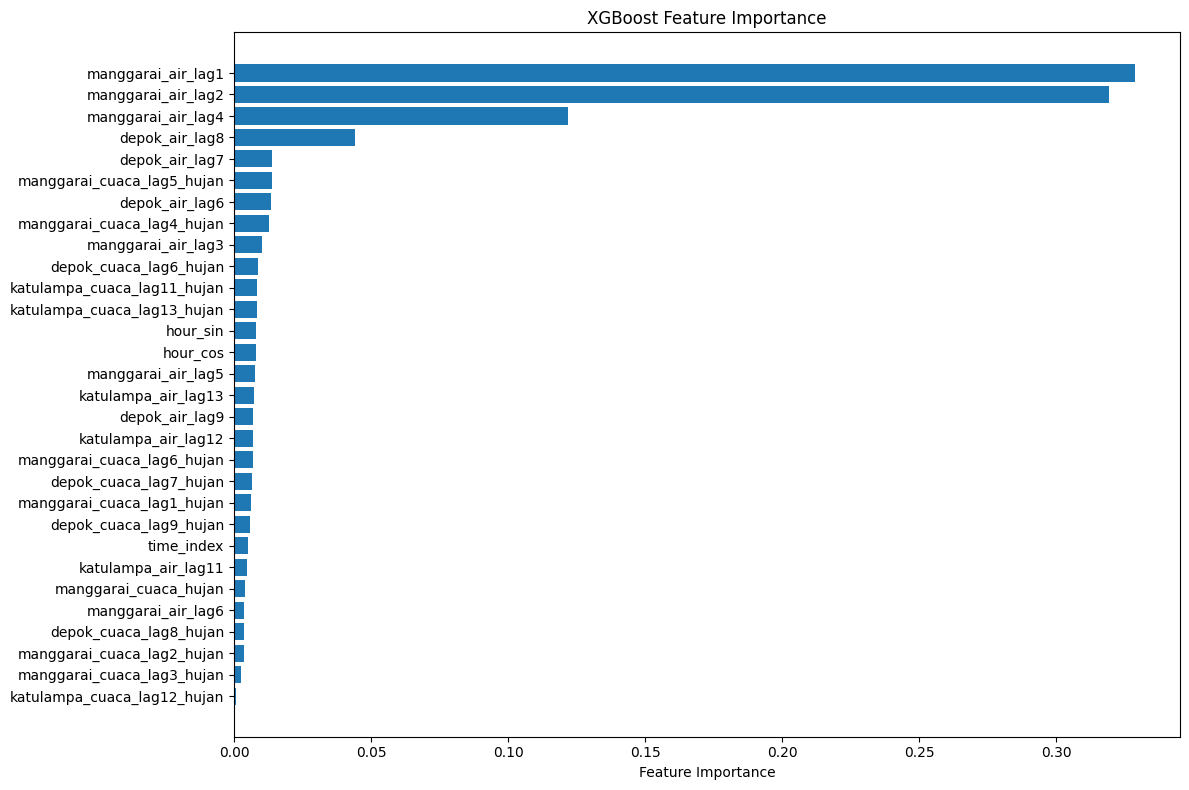

In [23]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Most Important Features:")
print(feature_importance.to_string(index=False))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Available evaluation results: ['validation_0']


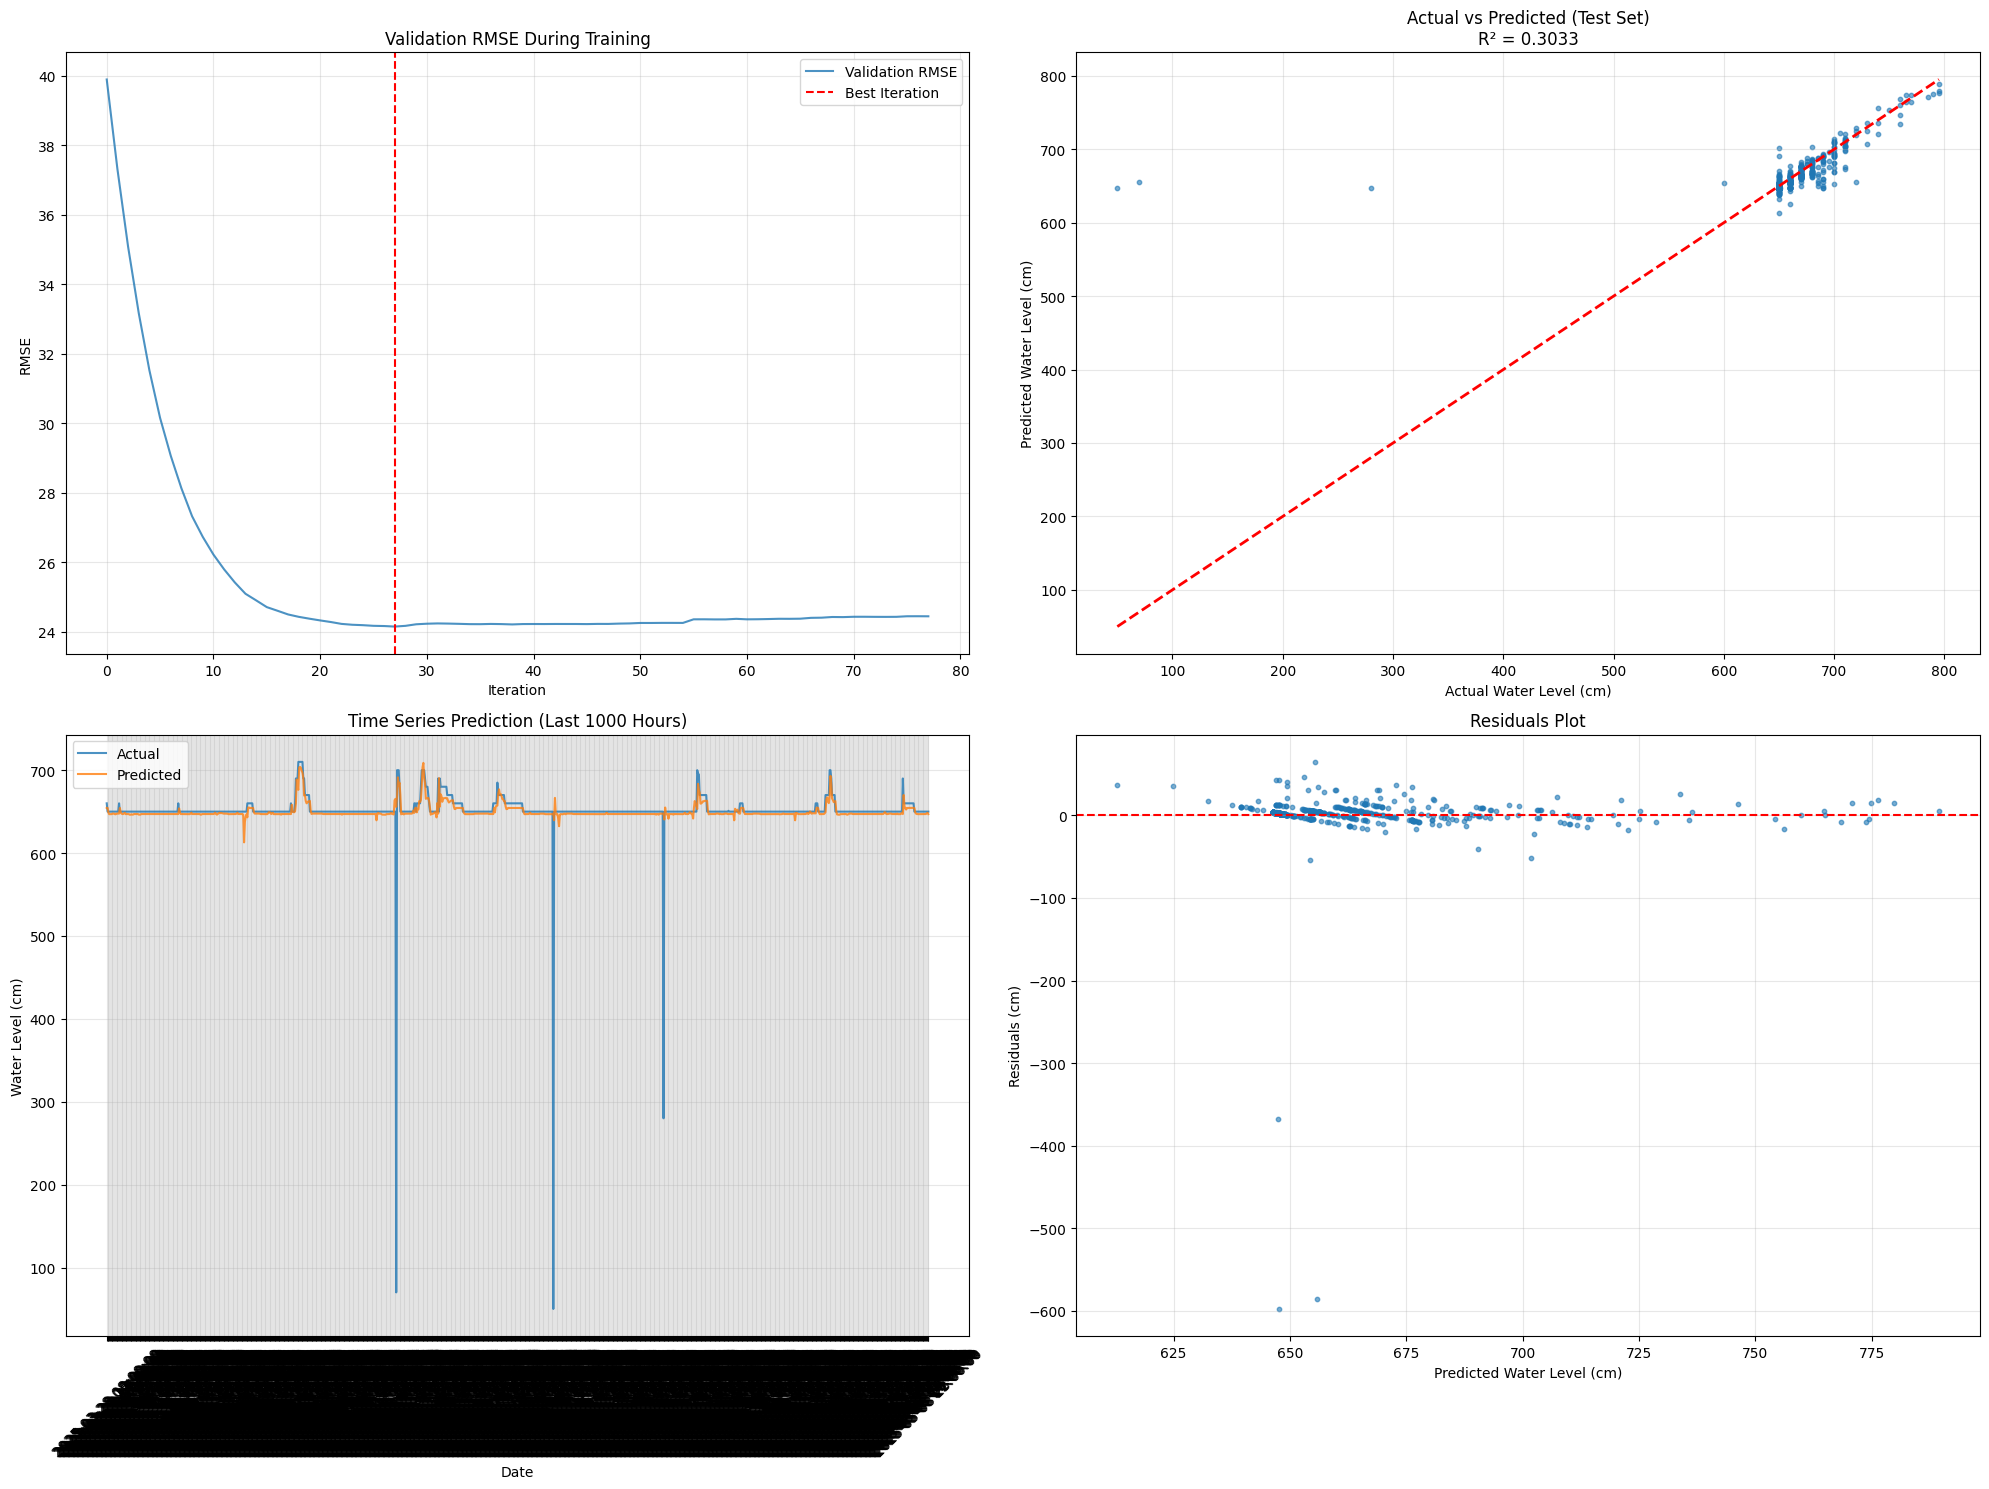

In [25]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# 1. Training and validation curves
# Check what evaluation results are available
eval_results = model.evals_result()
print("Available evaluation results:", list(eval_results.keys()))

if 'validation_0' in eval_results:
    axes[0, 0].plot(eval_results['validation_0']['rmse'], label='Validation RMSE', alpha=0.8)
    if hasattr(model, 'best_iteration') and model.best_iteration:
        axes[0, 0].axvline(x=model.best_iteration, color='red', linestyle='--', label='Best Iteration')
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('RMSE')
    axes[0, 0].set_title('Validation RMSE During Training')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
else:
    # If no evaluation results, show a simple message
    axes[0, 0].text(0.5, 0.5, 'No evaluation results available\n(Model trained without eval_set)',
                    ha='center', va='center', transform=axes[0, 0].transAxes)
    axes[0, 0].set_title('Training Progress')

# 2. Actual vs Predicted scatter plot
axes[0, 1].scatter(y_test, test_pred, alpha=0.6, s=10)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Water Level (cm)')
axes[0, 1].set_ylabel('Predicted Water Level (cm)')
axes[0, 1].set_title(f'Actual vs Predicted (Test Set)\nR² = {test_r2:.4f}')
axes[0, 1].grid(True, alpha=0.3)

# 3. Time series prediction plot (last 1000 points for clarity)
plot_points = min(1000, len(y_test))
test_subset = y_test.tail(plot_points).copy()
test_pred_subset = test_pred[-plot_points:]

axes[1, 0].plot(test_subset.index, test_subset,
                label='Actual', linewidth=1.5, alpha=0.8)
axes[1, 0].plot(test_subset.index, test_pred_subset,
                label='Predicted', linewidth=1.5, alpha=0.8)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Water Level (cm)')
axes[1, 0].set_title(f'Time Series Prediction (Last {plot_points} Hours)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Residuals plot
axes[1, 1].scatter(test_pred, residuals_test, alpha=0.6, s=10)
axes[1, 1].axhline(y=0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Predicted Water Level (cm)')
axes[1, 1].set_ylabel('Residuals (cm)')
axes[1, 1].set_title('Residuals Plot')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()